In [147]:
import numpy as np
import scipy.stats
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
def define_distribution_means(x):
    """
    Defines mean for y signal distribution
    
    :param x: message bits in {0;1}
    :return: mean_list: list of means for y_i distribution
    
    """    
    mean_list = [None]*7
    mean_list[0:4] = x
    mean_list[4] = (x[0] + x[1] + x[2]) % 2
    mean_list[5] = (x[1] + x[2] + x[3]) % 2
    mean_list[6] = (x[0] + x[2] + x[3]) % 2
    
    return mean_list

In [149]:
def get_p_y_fixed(y_fixed, x_input, sigma):
    """
    Get p(y|x) for fixed y
    
    :param y_fixed: fixed signal
    :param x_input: message bits in {0;1}
    :param sigma: distribution parameter
    :return: p_y_x: p(y|x) for fixed y
    
    """    
    x = define_distribution_means(x_input)
    p_y_x = [norm(x[index], sigma).pdf(y) for index, y in enumerate(y_fixed)]
    
    return p_y_x

In [150]:
def encoder(x_input, sigma):
    """
    Encodes X message bits into Y signal according to task description
    
    :param x: message bits in {0;1}
    :param sigma: distribution parameter
    :return: y: received signal
    
    """    
    x = define_distribution_means(x_input)
    
    y = [np.random.normal(xi, sigma) for xi in x] 
    
    return y
    

In [151]:
def decoder(y_signal, method, sigma, x_lenght = 4):
    """
    Encodes Y signal into initial X message, using specified method
    
    :param y_signal: received signal
    :param method: method in ["baseline", "MAP", "MM"]
    :return: x: initial message bits in {0;1}
    
    """ 
    if method == "baseline":
        return list(round(yi) for yi in y_signal[0:4])
    
    elif method == "MAP":
        all_solutions = list(itertools.product([0, 1], repeat=x_lenght))
        # x_prob = (1/2)**x_lenght - as it is equal - we can ignore it
        
        return all_solutions[np.argmax([np.prod(get_p_y_fixed(y_signal, x, sigma)) for x in all_solutions])]

    elif method == "MM":
        x_pred = [None]*x_lenght
        all_solutions = list(itertools.product([0, 1], repeat=x_lenght))
        for i in range(x_lenght):
            xi_one = np.sum([np.prod(get_p_y_fixed(y_signal, x, sigma)) for x in all_solutions if x[i]==1])
            xi_zero = np.sum([np.prod(get_p_y_fixed(y_signal, x, sigma)) for x in all_solutions if x[i]==0])
            if xi_one >= xi_zero:
                x_pred[i] = 1
            else:
                x_pred[i] = 0
        
        
        return x_pred
    
    else:
        raise ValueError("Unknown method. Please use method in ['baseline', 'MAP', 'MM']")
    

In [152]:
def error_calculator(true, pred):
    """
    Calculates two types of error: 
    Packet error rate: frequency of the case when not all bits of x’ are correct
    Bit error rate: the average number of bits that are wrong 
    
    :param true: original signal
    :param pred: decoded signal
    :return: err_pack: Packet error rate
    :return: err_bit: Bit error rate
    
    """ 
    
    broken_packet_count = 0
    wrong_bits_count = 0
    for ind, x in enumerate(true):
        diff_bits = [1 for i, j in zip(x, pred[ind]) if i != j]
        wrong_bits = int(np.sum(diff_bits))
        wrong_bits_count += wrong_bits
        if wrong_bits > 0:
            broken_packet_count+=1
    return broken_packet_count/len(true), wrong_bits_count/len(true)

In [153]:
methods = ["baseline", "MAP", "MM"]
sigma = 0.1

bit_error = {}
packet_error = {}

for method in methods:
    bit_error[method] = []
    packet_error[method] = []
    
for sigma in np.linspace(0.001, 2, 20):
    x_comb = list(itertools.product([0, 1], repeat=4))
    y_signals = [encoder(x, sigma) for x in x_comb]
    for method in methods:
        x_pred = [decoder(y_signal, method, sigma) for y_signal in y_signals]
        
        err_pack, err_bit = error_calculator(x_comb, x_pred)
        bit_error[method].append(err_bit)
        packet_error[method].append(err_pack)

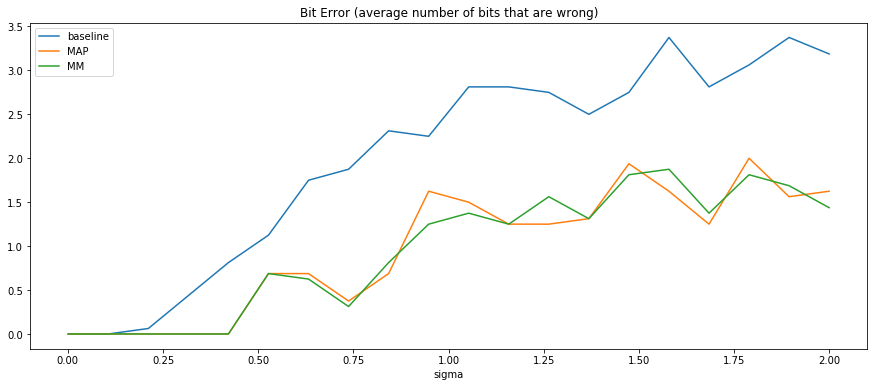

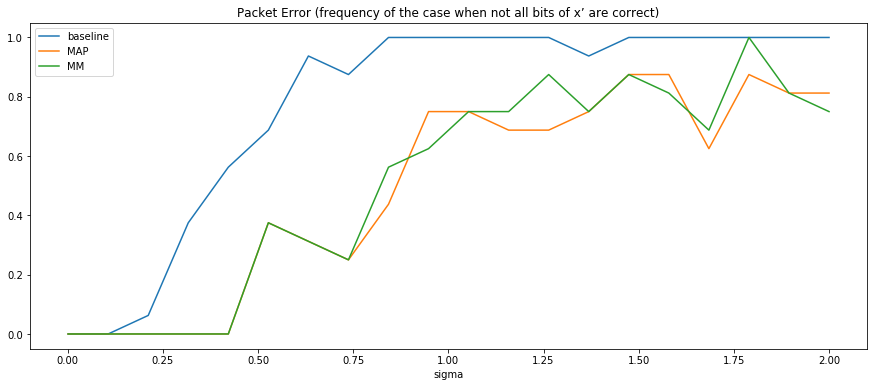

In [154]:
plt.figure(figsize = (15, 6))
plt.plot(np.linspace(0.001, 2, 20), bit_error["baseline"])
plt.plot(np.linspace(0.001, 2, 20), bit_error["MAP"])
plt.plot(np.linspace(0.001, 2, 20), bit_error["MM"])
plt.legend(['baseline','MAP','MM'])
plt.xlabel("sigma")
plt.title("Bit Error (average number of bits that are wrong)")
plt.show()


plt.figure(figsize = (15, 6))
plt.plot(np.linspace(0.001, 2, 20), packet_error["baseline"])
plt.plot(np.linspace(0.001, 2, 20), packet_error["MAP"])
plt.plot(np.linspace(0.001, 2, 20), packet_error["MM"])
plt.legend(['baseline','MAP','MM'])
plt.xlabel("sigma")
plt.title("Packet Error (frequency of the case when not all bits of x’ are correct)")
plt.show()

As we can see, <b>Baseline</b> method performs best for low noise.

But fot high noise <b>MM</b> method shows the best results according to packet error metric.

###### Time spent:
Understand task \ lecture malerial refresh - 2 hours

Additional reading - 30 mins

Coding \ debuging + report - 2 h 30 mins